In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from src.model_s import SSD300, MultiBoxLoss
from src.datasets_s import PascalVOCDataset
from src.utils_s import *
from src.datasets import MILDataset

In [3]:
import cv2

In [4]:
# Model training params

# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = 3  # number of different types of objects
BATCH_SIZE = 8
num_workers = 2

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = BATCH_SIZE  # batch size
iterations = 120000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

In [5]:
train_dataset = MILDataset('../dataset','train')

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [6]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2)

In [7]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True,
#                                                collate_fn=train_dataset.collate_fn, num_workers=1)

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.collate_fn,
                                          num_workers)

In [9]:
model = SSD300(n_classes=n_classes)


Loaded base model.



In [10]:
device = 'cpu'

In [11]:
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

/Users/user/opt/miniconda3/envs/cv-nd/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
# if checkpoint is None:
#     start_epoch = 0
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = SSD300(n_classes=n_classes)
    # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
biases = list()
not_biases = list()
for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)

In [13]:
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                lr=lr, momentum=momentum, weight_decay=weight_decay)

In [14]:
model.train()  # training mode enables dropout

batch_time = AverageMeter()  # forward prop. + back prop. time
data_time = AverageMeter()  # data loading time
losses = AverageMeter()  # loss

In [15]:
start = time.time()
epoch=1
for i, (images, boxes, labels) in enumerate(train_loader):


#         # Move to default device
    images = images.to(device)  # (batch_size (N), 3, 300, 300)

    
    boxes = [b.to(device) for b in boxes]
    labels = [l.to(device) for l in labels]

#         # Forward prop.
    predicted_locs, predicted_scores = model(images.float())  # (N, 8732, 4), (N, 8732, n_classes)

    loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar
    print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#     losses.update(loss.item(), images.size(0))
#     batch_time.update(time.time() - start)

#     start = time.time()

#     # Print status
#     if i % print_freq == 0:
#         print('Epoch: [{0}][{1}/{2}]\t'
#               'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
#               'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
#               'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, 
#                                                               i,
#                                                               len(train_loader),
#                                                               batch_time=batch_time,
#                                                               data_time=data_time, loss=losses))
del predicted_locs, predicted_scores, images, boxes, labels 

tensor(281.0392, grad_fn=<AddBackward0>)
tensor(229.4185, grad_fn=<AddBackward0>)
tensor(705.6584, grad_fn=<AddBackward0>)
tensor(249.4486, grad_fn=<AddBackward0>)
tensor(211.8573, grad_fn=<AddBackward0>)
tensor(227.4902, grad_fn=<AddBackward0>)
tensor(113.4068, grad_fn=<AddBackward0>)
tensor(872.4216, grad_fn=<AddBackward0>)
tensor(62.4757, grad_fn=<AddBackward0>)
tensor(307.4709, grad_fn=<AddBackward0>)
tensor(1760.8922, grad_fn=<AddBackward0>)
tensor(296.1142, grad_fn=<AddBackward0>)
tensor(296.2177, grad_fn=<AddBackward0>)
tensor(1346.4619, grad_fn=<AddBackward0>)
tensor(412.0185, grad_fn=<AddBackward0>)
tensor(1381.5045, grad_fn=<AddBackward0>)
tensor(1214.2771, grad_fn=<AddBackward0>)
tensor(393.7669, grad_fn=<AddBackward0>)
tensor(348.4363, grad_fn=<AddBackward0>)
tensor(406.6834, grad_fn=<AddBackward0>)
tensor(352.8801, grad_fn=<AddBackward0>)
tensor(913.7690, grad_fn=<AddBackward0>)
tensor(374.1053, grad_fn=<AddBackward0>)
tensor(158.2064, grad_fn=<AddBackward0>)
tensor(219.75

In [17]:
images, boxes, labels = train_dataset[0]

In [18]:
images = images.to(device)  # (batch_size (N), 3, 300, 300)
boxes = [b.to(device) for b in boxes]
labels = [l.to(device) for l in labels]

#         # Forward prop.
predicted_locs, predicted_scores = model(torch.reshape(images, (1,3,300,300)).float())  # (N, 8732, 4), (N, 8732, n_classes)
print(predicted_locs,predicted_scores)

tensor([[[-1.4205e+00,  1.7107e-03, -7.4574e-01,  1.9525e+00],
         [ 1.6049e-01,  9.2331e-01,  9.1722e-02,  1.2538e+00],
         [ 1.5384e+00,  3.6819e-01,  8.9321e-01, -5.8821e-01],
         ...,
         [-6.5413e-03,  1.3844e-02, -1.0446e-02, -5.3663e-04],
         [ 1.2681e-02, -4.7517e-03,  5.5588e-03, -3.7814e-04],
         [ 1.0598e-03,  5.0854e-03,  7.4291e-03,  1.0443e-02]]],
       grad_fn=<CatBackward>) tensor([[[ 0.2245,  0.7594, -0.8490],
         [ 0.0117, -0.1900,  0.6267],
         [-1.1676,  1.4681, -1.8477],
         ...,
         [-0.0073,  0.0022, -0.0123],
         [-0.0121,  0.0070, -0.0053],
         [ 0.0118, -0.0152, -0.0054]]], grad_fn=<CatBackward>)


In [65]:
predicted_locs.shape

torch.Size([1, 8732, 4])

In [64]:
predicted_scores.shape

torch.Size([1, 8732, 3])

hight = 792, wight=601, img_id=378882


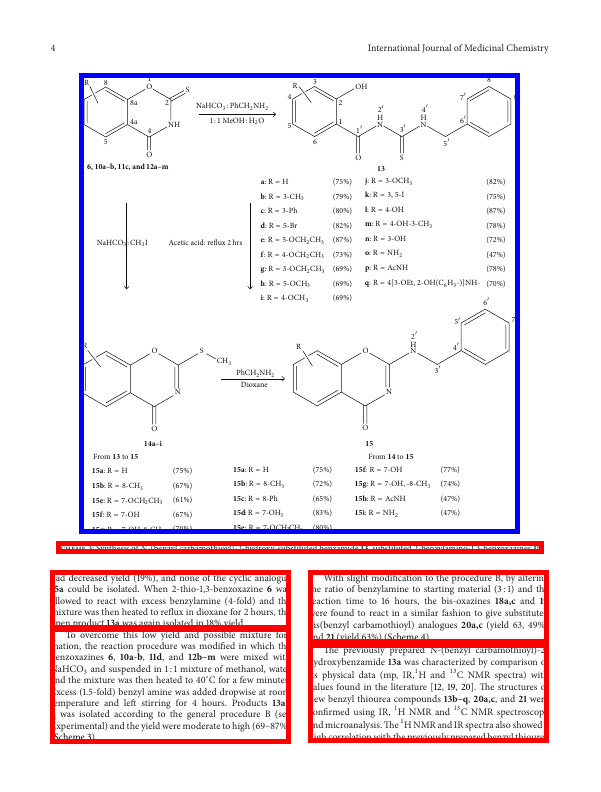

In [15]:
train_dataset.plot_image_w_bb(0)

In [20]:
from src.utils_s import find_intersection

In [25]:
find_intersection(torch.stack(boxes),torch.stack(boxes))

tensor([[2.9717e-02, 1.0442e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0442e-03, 5.8392e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.6642e-02, 3.5324e-05, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.5324e-05, 5.0270e-02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2466e-02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2605e-01]])

In [73]:
boxes[0]

tensor([0.0842, 0.7203, 0.4837, 0.7947])

In [74]:
torch.max(boxes[0][:, :2].unsqueeze(1), boxes[0][:, :2].unsqueeze(0))

IndexError: too many indices for tensor of dimension 1

In [30]:
torch.stack(labels)

tensor([1, 1, 1, 1, 1, 2])

In [32]:
torch.stack(boxes).shape

torch.Size([6, 4])

In [ ]:
torch.reshape(torch.stack(boxes), (1,6,4))

In [36]:
labels

[tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(2)]

In [39]:
torch.reshape(torch.stack(labels), (1,6))

tensor([[1, 1, 1, 1, 1, 2]])

In [40]:
criterion(predicted_locs, predicted_scores, torch.reshape(torch.stack(boxes), (1,6,4)), torch.reshape(torch.stack(labels), (1,6)))

tensor(17.0036, grad_fn=<AddBackward0>)

tensor(403.9733, grad_fn=<AddBackward0>)
tensor(336.0470, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [14]:
predicted_locs, predicted_scores = model(images.float())

In [15]:
predicted_scores

tensor([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]]], grad_fn=<CatBackward>)

In [16]:
predicted_locs

tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]],

        [[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         ...,
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]], grad_fn=<CatBackward>)

In [ ]:
model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // 32)
    decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)